# 1. Specify the system type

In [1]:
import warnings
warnings.filterwarnings("ignore")

# specify the system

from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Ncs_system'
which_system(plasma_system)
from numpy.random import uniform
from RBG_Maxwell.Collision_database.Ncs_system.collision_type import collision_type_for_all_species

# import ray
# ray.shutdown()
# ray.init(_temp_dir='/data/sunmingyan')

# 2. Specify the coefficient for unit conversion 

In [2]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [3]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
# dx = dy = dz = float(3*10**(-5))
dx = dy = dz = 0.001

# v_max = 48694781
v_max = 400

# maximum momentum
# momentum = float(4.43*10**(-23)) 
momentum = float(9.10938356*10**(-15)*v_max) 

# the momentum grid is set to be 
# half_px=half_pz=half_py=momentum
npx, npy, npz= 101, 5, 5
nx, ny, nz = 100, 5, 5


dpx = float(2*momentum/npx)
dpy = float(2*momentum/npy)
dpz = float(2*momentum/npz)
dp_volume = float(dpx*dpy*dpz)
dp = float((dpx+dpy+dpz)/3)

# time scale
dt = float(10**(-7))

# number of maximum particles in each phase grid
n_max = float(1*10**(5))

# number of averaged particles in each spatial grid
n_average = float(10**(5)/(60))

E = float(100)
B = float(0)

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx*dy*dz, dp, dp_volume,\
                                                                       n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
print("hbar: ",hbar)
print("c:     %.1e"%c)
print("lambdax: ",lambdax)
print("epsilon0: ",epsilon0)

hbar:  1e-20
c:     1.0e+09
lambdax:  1e-14
epsilon0:  1e-13


In [5]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [6]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma
import math

In [7]:
# time step, and spatial infinitesimals
dt, dx, dy, dz = float(dt*conversion_table['second']),\
                 float(dx*conversion_table['meter']), \
                 float(dy*conversion_table['meter']), \
                 float(dz*conversion_table['meter'])


# we have only one type of particle e-
num_particle_species = 2


# treat the electron as classical particles
particle_type = np.array([0,1])


# masses, charges and degenericies are
masses, charges, degeneracy = np.array([float(9.10938356*10**(-15)*conversion_table['kilogram']), \
                                         float(1.9625*10**(-5)*conversion_table['kilogram'])]), \
                              np.array([float(-1.602176634*10**(-9)*conversion_table['Coulomb']),\
                                        float(1.602176634*10**(-9)*conversion_table['Coulomb'])]),\
                              np.array([1,1])


# momentum grids5
npx, npy, npz = np.array([101,101]),np.array([5,5]),np.array([5,5])


# momentum range for y and z direction are not import in this case
half_px, half_py, half_pz = np.array([float(9.10938356*10**(-15)*v_max*conversion_table['momentum']),\
                                      float(9.10938356*10**(-15)*v_max*conversion_table['momentum'])]), \
                            np.array([float(9.10938356*10**(-15)*v_max*conversion_table['momentum']),\
                                      float(9.10938356*10**(-15)*v_max*conversion_table['momentum'])]),\
                            np.array([float(9.10938356*10**(-15)*v_max*conversion_table['momentum']),\
                                      float(9.10938356*10**(-15)*v_max*conversion_table['momentum'])])


dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz


# cpu caculation matrix
d_sigma = float(2.01765*10**(9)*conversion_table['meter']**2)

m1 = masses[0]
m2 = masses[1]

par_list=[m1**2*c**2, m2**2*c**2, (2*math.pi*hbar)**3, hbar**2*c, d_sigma/(hbar**2)]

# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [8]:
# number of spatial grids
# must be integers and lists
# odd numbers are recomended
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [nx], [ny], [nz]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-nx/2*dx],\
                                                 [-ny/2*dy],\
                                                 [-nz/2*dz]

# number samples gives the number of sample points in MC integration
num_samples = 10000

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 1

time_stride_back = 10
# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[],[],[],[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)

# 5. Specify the initial and boundary condition for plasma evolution

## Source term distribution

In [9]:
from numba import jit
num_momentum_levels = 1

# iniital distribution function
f = {}
f_middle = np.zeros([nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx[0], npy[0], npz[0]])
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx[0], npy[0], npz[0]])

# the momentum distribution is a Gaussian function
phase_space_volume = dx*dy*dz*dpx*dpy*dpz
# @jit
# def setup(npx,npy,npz,nx_o,ny_o,nz_o,f,r_v,p_v):
#     for ipx in range(npx):
#         for ipy in range(npy):
#             for ipz in range(npz):
#                 for ix in range(nx_o[0]):
#                     for iy in range(ny_o[0]):
#                         for iz in range(nz_o[0]):                       
#                             # current velocity
#                             f[ix,iy,iz,ipx,ipy,ipz] = r_v[ix,iy,iz]*p_v[ipx,ipy,ipz]
#     return f
@jit
def setup1(npx,npy,npz,nx_o,ny_o,nz_o,f,r_v,p_v):
    for ix in range(nx_o[0]):
        for iy in range(ny_o[0]):
            for iz in range(nz_o[0]):                       
                # current velocity
                f[ix,iy,iz] = r_v[ix,iy,iz]*p_v
    return f

# f_0

In [10]:
import math
v_collect = np.zeros([npx[0],npy[0],npz[0]])
for ipz in range(2,3,1):
    for ipy in range(2,3,1):
        for ipx in range(35,37,1):
            # current velocity
            v = 1
            v_collect[ipx, ipy, ipz] = v
p_v = (v_collect/v_collect.sum())

In [11]:
r_collect = np.zeros([nx_o[0],ny_o[0],nz_o[0]])
for iz in range(2,3,1):
    for iy in range(2,3,1):
        for ix in range(nx_o[0]):
            r = np.random.uniform(1,1.01,1)[0]
            r_collect[ix, iy, iz] = r
r_v = r_collect/r_collect.sum()*10**(0)

In [12]:
f[0][0][0] = setup1(npx[0],npy[0],npz[0],nx_o,ny_o,nz_o,f[0][0][0],r_v,p_v)

In [13]:
f[0][0][0].shape

(100, 5, 5, 101, 5, 5)

In [14]:
import math
v_collect = np.zeros([npx[0],npy[0],npz[0]])
for ipz in range(2,3,1):
    for ipy in range(2,3,1):
        for ipx in range(65,67,1):
            # current velocity
            v = 1 
            v_collect[ipx, ipy, ipz] = v
b_v = (v_collect/v_collect.sum())

In [15]:
sigma = 20
r_collect = np.zeros([nx_o[0],ny_o[0],nz_o[0]])
for iz in range(2,3,1):
    for iy in range(2,3,1):
        for ix in range(nx_o[0]):
            r = np.random.uniform(1,1.01,1)[0]
            r_collect[ix, iy, iz] = r
a_v = r_collect/r_collect.sum()*10**(0)

In [16]:
f_middle = setup1(npx[1],npy[1],npz[1],nx_o,ny_o,nz_o,f_middle,a_v,b_v)

In [17]:
f[0][0][0] = f[0][0][0]+f_middle

In [18]:
f[0][0][0].sum()*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]

0.00026138442828115097

# f_1 and f_2

In [19]:
import math
v_collect = np.zeros([npx[0],npy[0],npz[0]])
for ipz in range(2,3,1):
    for ipy in range(2,3,1):
        for ipx in range(50,51,1):
            # current velocity
            v = 1
            v_collect[ipx, ipy, ipz] = v
p_v = (v_collect/v_collect.sum())

In [20]:
r_collect = np.zeros([nx_o[0],ny_o[0],nz_o[0]])
for iz in range(2,3,1):
    for iy in range(2,3,1):
        for ix in range(nx_o[0]):
            r = np.random.uniform(1,1.01,1)[0]
            r_collect[ix, iy, iz] = r
r_v = r_collect/r_collect.sum()*2*10**(0)

In [21]:
f[0][0][1] = setup1(npx[0],npy[0],npz[0],nx_o,ny_o,nz_o,f[0][0][1],r_v,p_v)

In [22]:
f[0][0][1].sum()*dx*dy*dz*dpx[1]*dpy[1]*dpz[1]

0.00026138442828115086

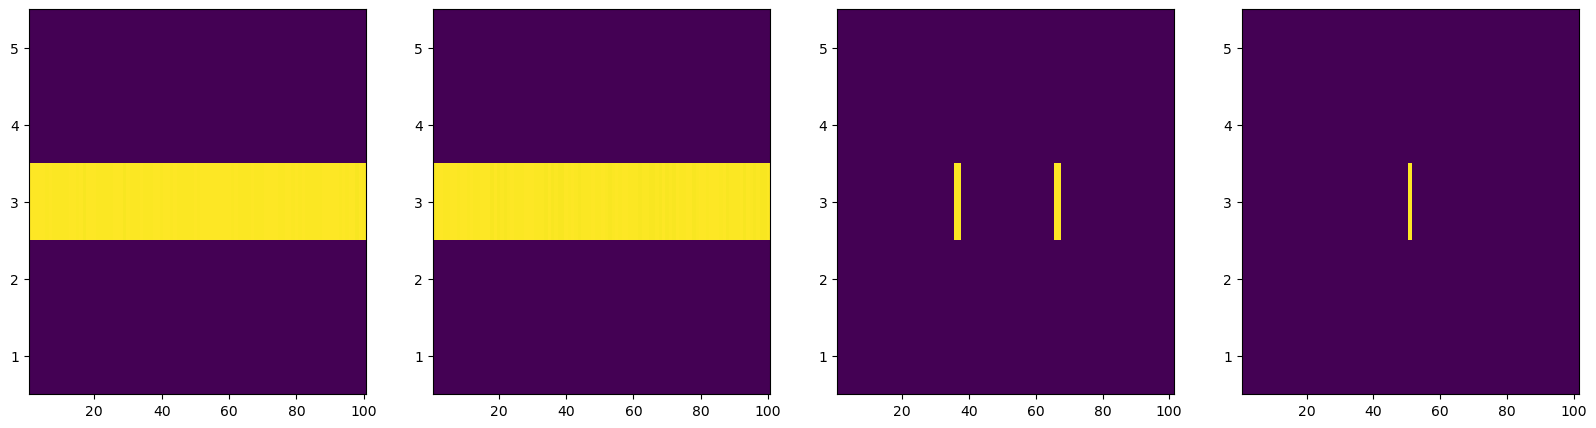

In [23]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:101:1,1:6:1]
xp, yp = np.mgrid[1:102:1,1:6:1]
fig, axes = plt.subplots(ncols=4, nrows=1, figsize = (20,5))
axes[0].pcolormesh(xi, yi, f[0][0][0][:,:,2].sum(axis=(-1,-2,-3)))
axes[1].pcolormesh(xi, yi, f[0][0][1][:,:,2].sum(axis=(-1,-2,-3)))
axes[2].pcolormesh(xp, yp, f[0][0][0][0][2][2][:,:,2])
axes[3].pcolormesh(xp, yp, f[0][0][1][0][2][2][:,:,2])

## Distribution conversion

In [24]:
# reshape the distribution function in different regions
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx[0]*npy[0]*npz[0]])

'''
We add an external magnetic field of 10 T in the +y direction
'''

BBx = [(2.9*10**10)*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
# BBy = [(1*10**(-6))*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
# BBz = [(1.8*10**(-5))*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BBy, BBz = [0],[0]
BEx, BEy, BEz = [0],[0],[0]


In [25]:
plasma = Plasma(f, dt,\
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                int(npx[0]), int(npy[0]), int(npz[0]), half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0,\
                num_samples = 100, drift_order = 2,\
                rho_J_method="raw", GPU_ids_for_each_region = ["3"])

len_time_snapshots: [1000]


2024-05-24 20:33:37,156	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8268 


# 6. Perform evolution 

In [26]:
n_step = 40001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
CT = []
real_time = []
import time
start_time = time.time()
for i_time in range(n_step):
    if i_time%200 == 0:
        print('Updating the {}-th time step - dis'.format(i_time))
    if i_time%100 == 0:
        dis.append(plasma.acquire_values("Distribution"))
        
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':1., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)  
    if i_time%100 == 0:
        EM.append(plasma.acquire_values('EM fields on current region'))

end_time = time.time()
print((end_time-start_time)/3600,'hours')

Updating the 0-th time step - dis
(Plasma_single_GPU pid=181842) Using context GPU-106269f1-bc7a-a5ac-efc8-db0fd6f7c94d for region 0.


(Plasma_single_GPU pid=181842) /data/smy/anaconda3/envs/sun/lib/python3.7/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (79) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
(Plasma_single_GPU pid=181842)   warn(NumbaPerformanceWarning(msg))
(Plasma_single_GPU pid=181842) /data/smy/anaconda3/envs/sun/lib/python3.7/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (79) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
(Plasma_single_GPU pid=181842)   warn(NumbaPerformanceWarning(msg))


Updating the 200-th time step - dis
Updating the 400-th time step - dis
Updating the 600-th time step - dis
Updating the 800-th time step - dis
Updating the 1000-th time step - dis
Updating the 1200-th time step - dis
Updating the 1400-th time step - dis
Updating the 1600-th time step - dis
Updating the 1800-th time step - dis
Updating the 2000-th time step - dis
Updating the 2200-th time step - dis
Updating the 2400-th time step - dis
Updating the 2600-th time step - dis
Updating the 2800-th time step - dis
Updating the 3000-th time step - dis
Updating the 3200-th time step - dis
Updating the 3400-th time step - dis
Updating the 3600-th time step - dis
Updating the 3800-th time step - dis
Updating the 4000-th time step - dis
Updating the 4200-th time step - dis
Updating the 4400-th time step - dis
Updating the 4600-th time step - dis
Updating the 4800-th time step - dis
Updating the 5000-th time step - dis
Updating the 5200-th time step - dis
Updating the 5400-th time step - dis
Updat

# Results

In [27]:
time = len(dis)
result = np.zeros((time,nx_o[0],npx[0]))
print(time,nx,npx[0])
for t in range(time):
    for ix in range(nx_o[0]):
        for ipx in range(npx[0]):
            result[t][ix][ipx] = dis[t][0].reshape([num_momentum_levels, num_particle_species,nx_o[0],ny_o[0],nz_o[0],npx[0],npy[0],npz[0]])\
                                        [0,0,ix,:,:,ipx,:,:].mean()
            

401 100 101


In [28]:
time

401

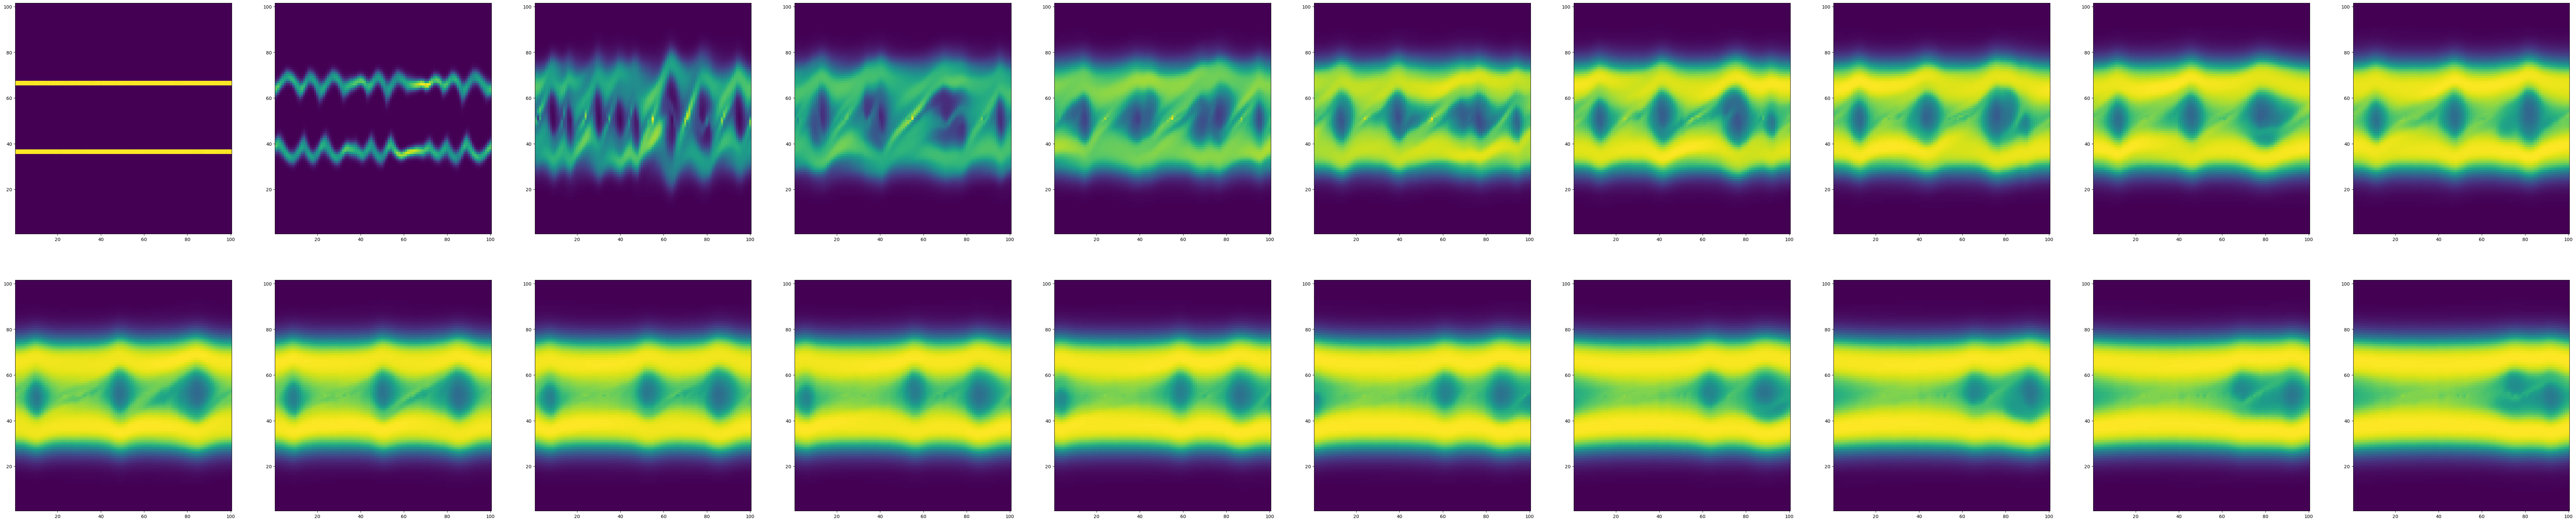

In [29]:
# import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:101:1,1:102:1]
fig, axes = plt.subplots(ncols=10, nrows=2, figsize = (100,20))
number = 0
for ii in range(2):
    for jj in range(10):
        axes[ii,jj].pcolormesh(xi, yi,  result[(jj+ii*10+number)*20][:])

In [30]:
time = len(dis)
particle_number_ = np.zeros(time)
kinetic_energy_ = np.zeros(time)
momentum_x = np.zeros(time)
momentum_y = np.zeros(time)
momentum_z = np.zeros(time)

for t in range(time):
    f_temp = dis[t][0].reshape([num_momentum_levels, num_particle_species,nx_o[0],ny_o[0],nz_o[0],npx[0],npy[0],npz[0]])
    particle_number_[t] = f_temp.sum()*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]
    
    for ipx in range(npx[0]):
        px = (ipx-npx[0]/2+0.5)*dpx[0]
        for ipy in range(npy[0]):
            py = (ipy-npy[0]/2+0.5)*dpy[0]
            for ipz in range(npz[0]):
                pz = (ipz-npz[0]/2+0.5)*dpz[0]
                p2 = px**2+py**2+pz**2
                energy = math.sqrt(p2*c**2+masses[0]**2*c**4) - masses[0]*c**2
                kinetic_energy_[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*energy*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]
                momentum_x[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*px*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]
                momentum_y[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*py*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]
                momentum_z[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*pz*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]

In [31]:
norm_E = kinetic_energy_[0]
norm_p = momentum_x[0]
norm_f = particle_number_[0]

In [37]:
ni = dis[0][0].reshape([num_momentum_levels, num_particle_species,\
                        nx_o[0],ny_o[0],nz_o[0],npx[0],npy[0],npz[0]])\
[0,0].sum(axis=(-1,-2,-3))[:, :, :].mean()*dpx[0]*dpy[0]*dpz[0]/conversion_table_reverse["TO_meter"]**3
epsilon = 8.854187817*10**(-12)
e = 1.602176634*10**(-9)
me = float(9.10938356*10**(-15))
wp = math.sqrt((ni*e**2)/(me*epsilon))
gamma = wp/math.sqrt(2)
gamma

40789.312722719194

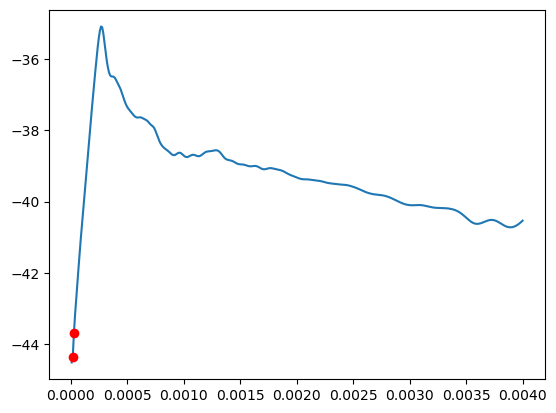

calculated slop (gamma):  32608.260495075916 2 3


In [83]:
field_energy = np.array([(epsilon0*np.abs(EM[i][0][0]**2)).sum()*dx*dy*dz\
                             for i in range(0,len(EM),1)])
x = 100*np.arange(len(field_energy))*dt*conversion_table_reverse["TO_second"]

plt.plot(x,np.log(field_energy*conversion_table_reverse["TO_Joules"]))

id1, id2 = 11, 13
maximum = []
for id1 in range(1,30):
    for id2 in range(1,30):
        if id1 != id2:
            points_x = [x[id1], x[id2]]  # 或者直接使用 x 的计算值，如 [19*dt*conversion_table_reverse["TO_second"], 200*dt*conversion_table_reverse["TO_second"]]
            points_y = [np.log(field_energy[id1] * conversion_table_reverse["TO_Joules"]), 
                    np.log(field_energy[id2] * conversion_table_reverse["TO_Joules"])]
            maximum.append([id1, id2, (points_y[1]-points_y[0])/(points_x[1]-points_x[0])])
maximum = np.array(maximum)    
max_index = np.argmax(maximum[:, 2])
max_row = maximum[max_index]

id1, id2 = int(max_row[0]), int(max_row[1])
points_x = [x[id1], x[id2]]  # 或者直接使用 x 的计算值，如 [19*dt*conversion_table_reverse["TO_second"], 200*dt*conversion_table_reverse["TO_second"]]
points_y = [np.log(field_energy[id1] * conversion_table_reverse["TO_Joules"]), 
        np.log(field_energy[id2] * conversion_table_reverse["TO_Joules"])]
    
plt.scatter(points_x, points_y, color='red', zorder=5)

plt.show()

print('calculated slop (gamma): ', (points_y[1]-points_y[0])/(points_x[1]-points_x[0])/2, id1, id2)

In [81]:
np.savetxt('groth rate 2ed', np.array([x,np.log(field_energy*conversion_table_reverse["TO_Joules"])]), delimiter=',')

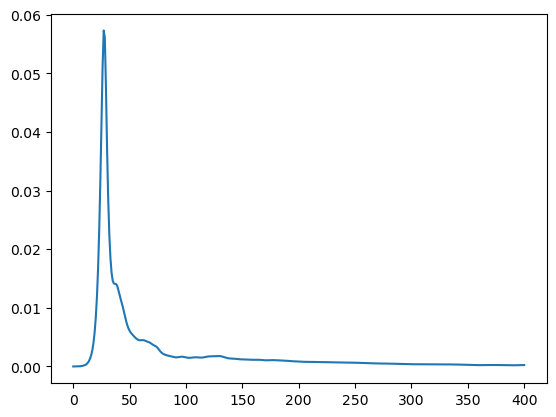

In [82]:
field_energy = np.array([(epsilon0*(EM[i][0][0])**2).sum()*dx*dy*dz\
                             for i in range(0,len(EM),1)])
x = np.arange(len(field_energy))

plt.plot(x,field_energy)

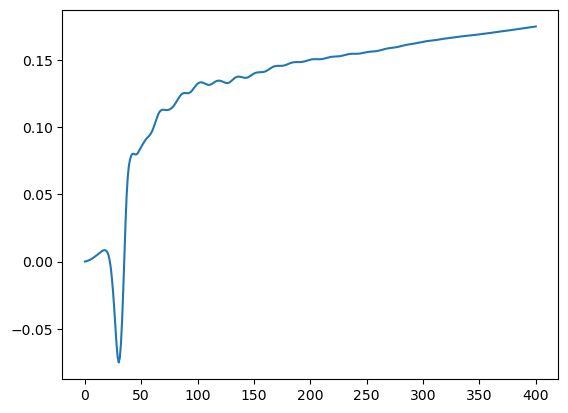

In [37]:
x = np.arange(len(kinetic_energy_))

plt.plot(x,kinetic_energy_-norm_E)

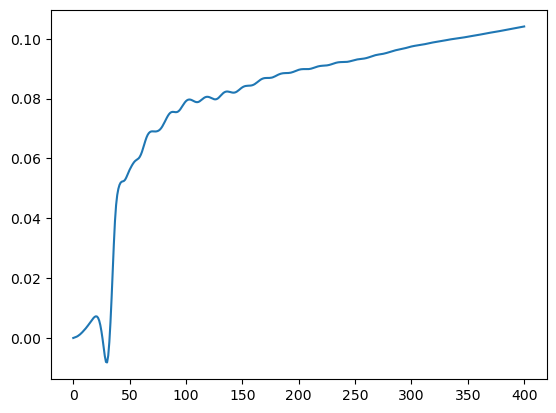

In [38]:
x = np.arange(len(kinetic_energy_))

plt.plot(x,(kinetic_energy_+field_energy-norm_E)/norm_E)

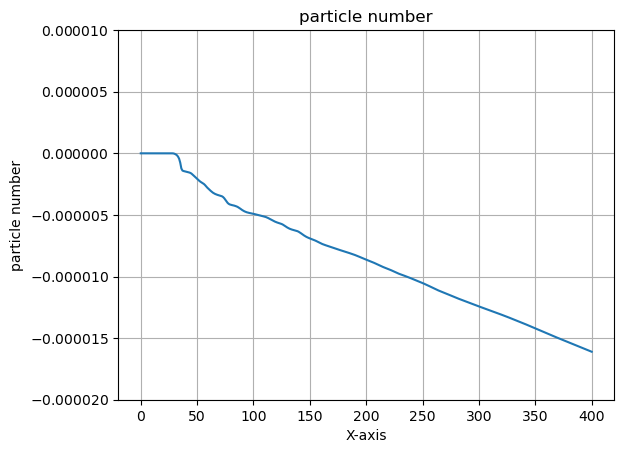

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

x = np.arange(len(momentum_x))

plt.plot(x, (particle_number_-particle_number_[0])/particle_number_[0])

# 设置y轴范围为0到1e13
plt.ylim(-0.00002, 0.00001)

# 使用ScalarFormatter来取消科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)  # 取消科学计数法
formatter.set_powerlimits((-5, 5))

ax = plt.gca()  # 获取当前轴
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('X-axis')
plt.ylabel('particle number')
plt.title('particle number')
plt.grid(True)

plt.show()

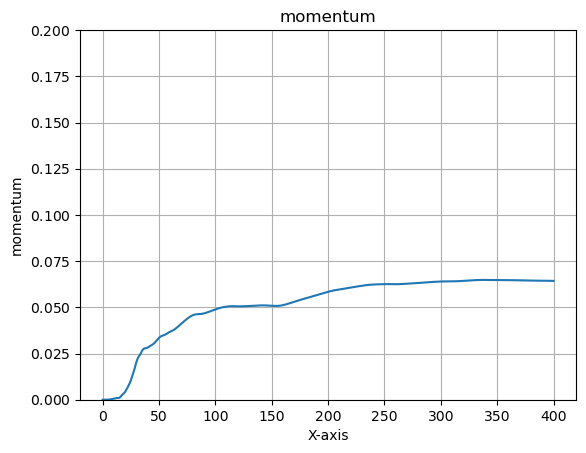

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

x = np.arange(len(momentum_x))

plt.plot(x, (momentum_x-momentum_x[0])/momentum_x[0])

# 设置y轴范围为0到1e13
plt.ylim(0, 0.2)

# 使用ScalarFormatter来取消科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)  # 取消科学计数法
formatter.set_powerlimits((-5, 5))

ax = plt.gca()  # 获取当前轴
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('X-axis')
plt.ylabel('momentum')
plt.title('momentum')
plt.grid(True)

plt.show()

In [47]:
np.savetxt('phase diagram 2ed', np.array([result[i] for i in [0,100,200,300]]).flatten(), delimiter=',')
np.savetxt('conservation and energy conversion 2ed', np.array([field_energy, kinetic_energy_-norm_E, (kinetic_energy_+field_energy-norm_E)/norm_E,\
          (particle_number_-particle_number_[0])/particle_number_[0], (momentum_x-momentum_x[0])/momentum_x[0]]).flatten(), delimiter=',')